In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np
import snntorch as snn
import os
import pandas as pd

In [148]:
seed = 2002
torch.manual_seed(seed)
np.random.seed(seed)

In [149]:
file_path = '/home/hwkang/TSB-AD/Datasets/TSB-AD-M/065_SMD_id_9_Facility_tr_737_1st_837.csv'

In [150]:
window_size = 100

In [151]:
idx_start = 790
idx_end = idx_start + window_size

In [152]:
num_in_features = 2
num_out_features = 1

In [153]:
real = True

In [154]:
if real:
    df = pd.read_csv(file_path).dropna()
    data = df.iloc[idx_start:idx_end, 0:num_in_features].values.astype(float)
    label = df['Label'].astype(int).to_numpy()
    # normalize data
    normalize = True
    if normalize:
        data = (data - np.min(data)) / (np.max(data) - np.min(data))
else:
    data = torch.zeros((num_in_features, window_size))
    # First channel
    data[0, 20:40] = 1
    data[0, 60:95] = 1
    # Second channel
    #data[1, 10:30] = 1
    #data[1, 50:85] = 1
    data[1, 20:40] = 1
    data[1, 60:95] = 1

In [155]:
conv = nn.Conv1d(num_in_features, num_out_features, kernel_size=3, stride=1, padding='same')
init.kaiming_normal_(conv.weight, mode='fan_in', nonlinearity='relu')
#norm = nn.BatchNorm1d(100)
norm = nn.LayerNorm((window_size))

In [156]:
binary = True # False-> ternary

In [157]:
class TernarySpikingNeuron(snn._neurons.leaky.Leaky):
    def __init__(self, beta, pos_threshold, neg_threshold, spike_grad=None,
                 surrogate_disable=False, init_hidden=True, inhibition=False,
                 learn_beta=False, reset_mechanism="subtract",
                 state_quant=False, output=True, graded_spikes_factor=1.0,
                 learn_graded_spikes_factor=False, reset_delay=True):
        super(TernarySpikingNeuron, self).__init__(beta=beta,
                                                     threshold=1.0,
                                                     spike_grad=spike_grad,
                                                     surrogate_disable=surrogate_disable,
                                                     init_hidden=init_hidden,
                                                     inhibition=inhibition,
                                                     learn_beta=learn_beta,
                                                     learn_threshold=False,
                                                     reset_mechanism=reset_mechanism,
                                                     state_quant=state_quant,
                                                     output=output,
                                                     graded_spikes_factor=graded_spikes_factor,
                                                     learn_graded_spikes_factor=learn_graded_spikes_factor,
                                                     reset_delay=reset_delay)
        self.pos_threshold = pos_threshold
        self.neg_threshold = neg_threshold
    
    def fire(self, mem):
        if self.state_quant:
            mem = self.state_quant(mem)

        mem_shift_pos = mem - self.pos_threshold
        mem_shift_neg = self.neg_threshold - mem

        spk_pos = self.spike_grad(mem_shift_pos)
        spk_neg = self.spike_grad(mem_shift_neg)

        spk = spk_pos - spk_neg
        spk = spk * self.graded_spikes_factor
        return spk

In [158]:
base_thr_s = 0.5
base_thr_n = 3.0
base_thr_f = 0.9

In [159]:
if binary:
    s_receptor = snn.Leaky(beta=0.85, threshold=base_thr_s, spike_grad=None, reset_mechanism='zero', init_hidden=True, output=True)
    n_receptor = snn.Leaky(beta=0.95, threshold=base_thr_n, spike_grad=None, reset_mechanism='subtract', init_hidden=True, output=True)
    f_receptor = snn.Leaky(beta=0.7, threshold=base_thr_f, spike_grad=None, reset_mechanism='subtract', init_hidden=True, output=True)
else:
    s_receptor = TernarySpikingNeuron(beta=0.85, pos_threshold=0.7, neg_threshold=0.3, spike_grad=None, reset_mechanism='zero')
    n_receptor = TernarySpikingNeuron(beta=0.95, pos_threshold=3.0, neg_threshold=1.0, spike_grad=None, reset_mechanism='subtract')

In [160]:
# if data is numpy array
if isinstance(data, np.ndarray):
    stimulus = torch.from_numpy(data).float().permute(1, 0) # (C, L)
else:
    stimulus = data

In [161]:
def init_records(binary=True):
    mem_rec = []
    spk_rec = []
    if binary:
        thr_rec = []
    else:
        p_thr_rec = []
        n_thr_rec = []
    return mem_rec, spk_rec, thr_rec if binary else (p_thr_rec, n_thr_rec)

In [162]:
adapt_gain = 1.6
recovery_decay = 0.95
min_thr = 0.3

In [163]:
if binary:
    s_spk_rec, s_mem_rec, s_thr_rec = init_records(binary)
    n_spk_rec, n_mem_rec, n_thr_rec = init_records(binary)
    f_spk_rec, f_mem_rec, f_thr_rec = init_records(binary)
else:
    s_spk_rec, s_mem_rec, (s_p_thr_rec, s_n_thr_rec) = init_records(binary)
    n_spk_rec, n_mem_rec, (n_p_thr_rec, n_n_thr_rec) = init_records(binary)
    f_spk_rec, f_mem_rec, (f_p_thr_rec, f_n_thr_rec) = init_records(binary)

In [164]:
activation = conv(stimulus) # (C, L)

# Normalization through layer
#activation = norm(activation)

# Min-max normalization
activation = (activation - torch.min(activation)) / (torch.max(activation) - torch.min(activation))

In [165]:
timesteps = activation.shape[1]

for step in range(timesteps):
    
    s_spk, s_mem = s_receptor(activation[0, step]) # (C), (C) <- (C, L)
    n_spk, n_mem = n_receptor(activation[0, step])

    if step == 0:
        delta_activation = activation[0, step]
    else:
        delta_activation = activation[0, step] - activation[0, step-1]
    f_spk, f_mem = f_receptor(torch.abs(delta_activation)) # (C), (C) <- (C, L)

    # Adaption and Recovery
    if binary:
        
        if s_spk.item() > 0: # Adaption # 50% of neurons spiking
            s_receptor.threshold = s_receptor.threshold * adapt_gain
        else: # Recovery
            #s_receptor.threshold = torch.max(torch.ones_like(s_receptor.threshold) * min_thr, s_receptor.threshold - recovery_rate)
            s_receptor.threshold = torch.max(torch.ones_like(s_receptor.threshold) * min_thr, 
                                             base_thr_s + (s_receptor.threshold - base_thr_s) * recovery_decay)

        s_spk_rec.append(s_spk.detach())
        s_mem_rec.append(s_mem.detach())
        s_thr_rec.append(s_receptor.threshold)

        n_spk_rec.append(n_spk.detach())
        n_mem_rec.append(n_mem.detach())
        n_thr_rec.append(n_receptor.threshold)

        f_spk_rec.append(f_spk.detach())
        f_mem_rec.append(f_mem.detach())
        f_thr_rec.append(f_receptor.threshold)
    else:
        pass

In [166]:
burst_kernel = [1, 1, 1]

In [167]:
# Stacking
if binary:
    s_spk_rec = torch.stack(s_spk_rec)
    s_mem_rec = torch.stack(s_mem_rec)
    s_thr_rec = torch.stack(s_thr_rec)

    # Sensitization
    n_spk_rec = torch.stack(n_spk_rec)
    n_spk_rec = F.conv1d(n_spk_rec.unsqueeze(0), torch.tensor(burst_kernel).unsqueeze(0).unsqueeze(0).float(), padding=1)
    n_spk_rec = (n_spk_rec.squeeze(0) > 0).float()

    n_mem_rec = torch.stack(n_mem_rec)
    n_thr_rec = torch.stack(n_thr_rec)

    f_spk_rec = torch.stack(f_spk_rec)
    f_mem_rec = torch.stack(f_mem_rec)
    f_thr_rec = torch.stack(f_thr_rec)
else:
    pass

In [ ]:
def plot_binary():
    # find the first index of the label
    first_anomaly_idx = np.where(label[idx_start:idx_end] == 1)[0][0]
    last_anomaly_idx = np.where(label[idx_start:idx_end] == 1)[0][-1]

    fig, axs = plt.subplots(10, 1, figsize=(10, 12), sharex=True)
    fig.suptitle('Dynamic Receptive Encoding', fontsize=16)
    # 1 Input stimulus
    # title left top
    axs[0].set_title('Input stimulus', loc='left', fontsize=11) 
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
    for i in range(num_in_features):
        axs[0].plot(stimulus[i], label=f'Input {i+1}', color=colors[i])
    axs[0].scatter(np.where(label[idx_start:idx_end] == 1)[0], np.ones(np.sum(label[idx_start:idx_end] == 1)), color='black', label='Label', s=4)

    # 2 Receptor potential
    axs[1].set_title('Receptor potential', loc='left', fontsize=11)
    axs[1].plot(activation.squeeze(0).squeeze(0).detach().numpy(), label='Receptor potential', color='green')
    axs[1].axhline(0, color='black', lw=0.5, ls='--')

    # 3 Membrane potential of s_receptor
    axs[2].set_title('Membrane potential of s_receptor', loc='left', fontsize=11)
    axs[2].plot(s_mem_rec.numpy(), label='Membrane potential', color='blue')
    axs[2].scatter(np.arange(len(s_thr_rec)), s_thr_rec.numpy(), color='red', label='Threshold', s=4) # Threshold

    # 4 Spiking activity of s_receptor
    axs[3].set_title('Spiking activity of s_receptor', loc='left', fontsize=11)
    axs[3].plot(s_spk_rec.numpy(), label='Spikes', color='red')
    axs[3].eventplot(np.where(s_spk_rec.numpy() > 0)[0], color='black', label='Spikes', linelengths=0.25)

    # 5 Membrane potential of n_receptor
    axs[4].set_title('Membrane potential of n_receptor', loc='left', fontsize=11)
    axs[4].plot(n_mem_rec.numpy(), label='Membrane potential', color='blue')
    axs[4].scatter(np.arange(len(n_thr_rec)), n_thr_rec.numpy(), color='red', label='Threshold', s=4) # Threshold

    # 6 Spiking activity of n_receptor
    axs[5].set_title('Spiking activity of n_receptor', loc='left', fontsize=11)
    axs[5].plot(n_spk_rec.numpy(), label='Spikes', color='red')
    axs[5].eventplot(np.where(n_spk_rec.numpy() > 0)[0], color='black', label='Spikes', linelengths=0.25)

    # 7 Membrane potential of f_receptor
    axs[6].set_title('Membrane potential of f_receptor', loc='left', fontsize=11)
    axs[6].plot(f_mem_rec.numpy(), label='Membrane potential', color='blue')
    axs[6].scatter(np.arange(len(f_thr_rec)), f_thr_rec.numpy(), color='red', label='Threshold', s=4) # Threshold
    
    # 8 Spiking activity of f_receptor
    axs[7].set_title('Spiking activity of f_receptor', loc='left', fontsize=11)
    axs[7].plot(f_spk_rec.numpy(), label='Spikes', color='red')
    axs[7].eventplot(np.where(f_spk_rec.numpy() > 0)[0], color='black', label='Spikes', linelengths=0.25)

    # L Combined Spiking activity
    axs[8].set_title('Combined Spiking activity', loc='left', fontsize=11)
    axs[8].plot(s_spk_rec.numpy()+n_spk_rec.numpy()+f_spk_rec.numpy(), label='Combined Spikes', color='purple')
    axs[8].eventplot(np.where(s_spk_rec.numpy()+n_spk_rec.numpy()+f_spk_rec.numpy() > 0)[0], color='black', label='Combined Spikes', linelengths=0.25)

    # ReLU activation
    axs[9].set_title('ReLU activation', loc='left', fontsize=11)
    relu_activation = F.relu(activation.squeeze(0).squeeze(0).detach())
    axs[9].plot(relu_activation, label='ReLU activation', color='green')
    axs[9].axhline(0, color='black', lw=0.5, ls='--')

    # Common X-axis
    axs[-1].set_xlabel('Timesteps')

    # draw vertical line at idx_start for all subplots
    for ax in axs:
        ax.axvline(x=first_anomaly_idx, color='black', lw=0.5, ls='--')
        ax.axvline(x=last_anomaly_idx, color='black', lw=0.5, ls='--')
        
    plt.tight_layout()
    plt.show()

def plot_ternary():
    pass

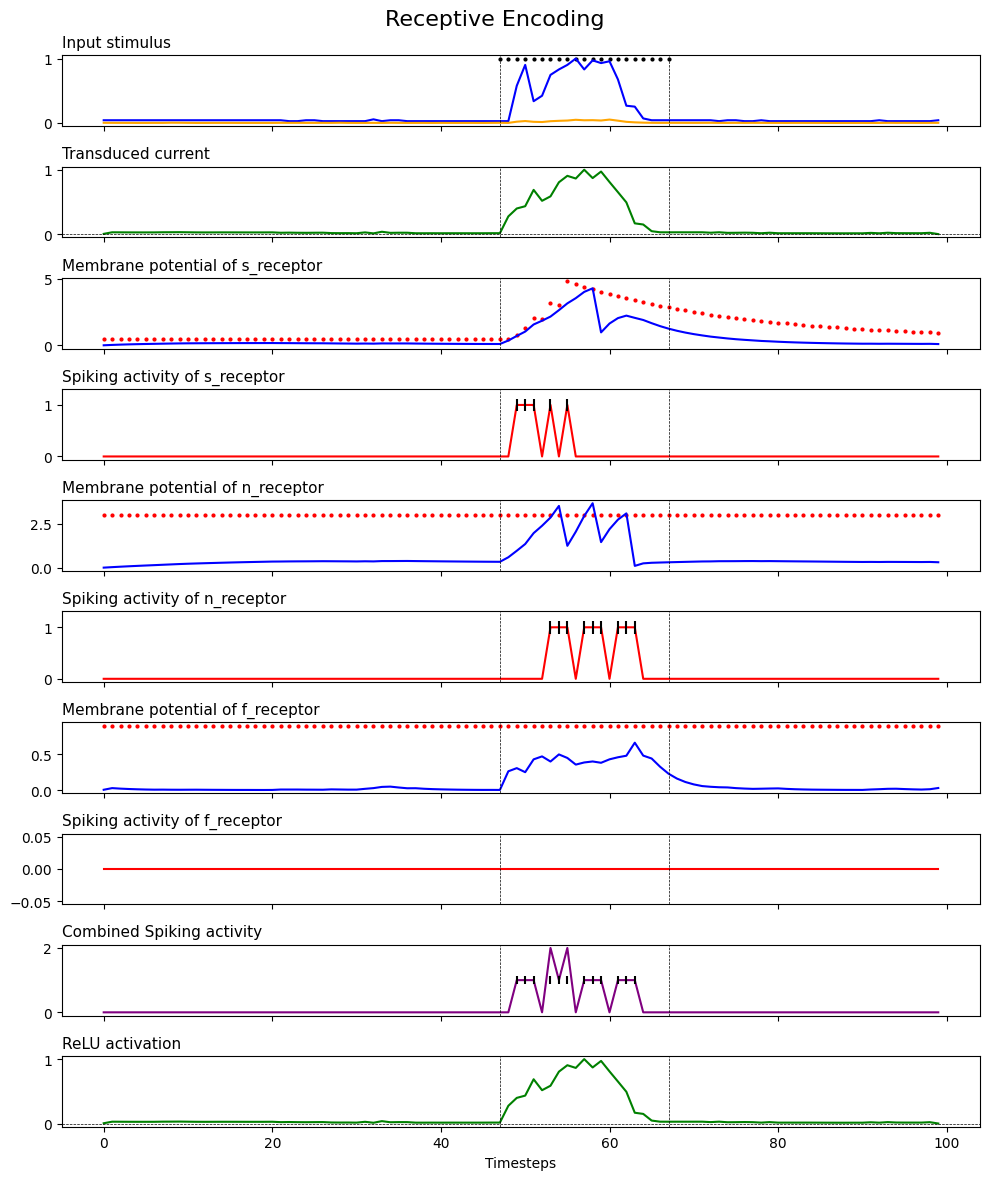

In [169]:
plot_binary()